In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
from single_photons.utils.constants import *
from single_photons.environment import Particle

In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [56]:
gamma = 8500
coupling = 0.01
eta_detec=0.9
env = Particle(omega, gamma, coupling, eta_detection=eta_detec)

In [57]:
variance_process = 2*env.__gamma__ + np.power(env.backaction, 2)
std_detection = 100

In [58]:
Q = np.array([[0, 0], [0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [59]:
Ad = np.eye(2)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [60]:
P0 = 100*np.matrix(np.eye(2))
estimation = np.matrix([[0],[0]])
states = np.array([[100],[0.]])
K = np.array([[1, 1e5]])
new_states = np.zeros((N,2)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q, R)
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 2))
estimated_states[0,:] = estimation.reshape((2))
estimation = estimation.reshape((2,1))
for i in tqdm(range(t.shape[0])):
    new_states[i,:] = states[:,0]
    measured_states[i] = states[0, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[0]]))
    kalman.compute_aposteriori(measured_states[i])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((2))
    estimation = estimated_states[i,:].reshape((2,1))    
    states = env.step(states, control=0, delta_t=delta_t)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:07<00:00, 5344.21it/s]


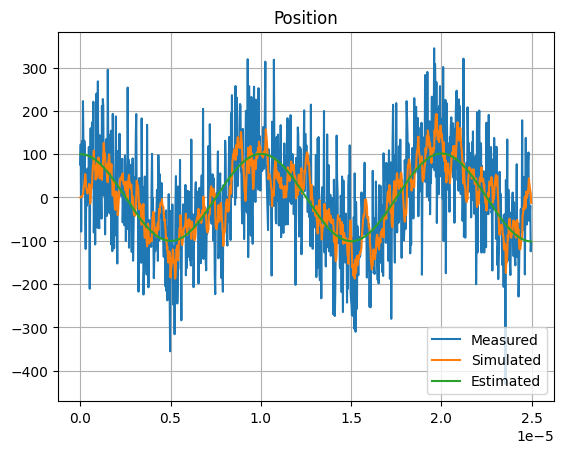

In [61]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t[:1000], measured_states[:1000])
plt.plot(t[:1000], estimated_states[:1000,0])
plt.plot(t[:1000], new_states[:1000,0])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()

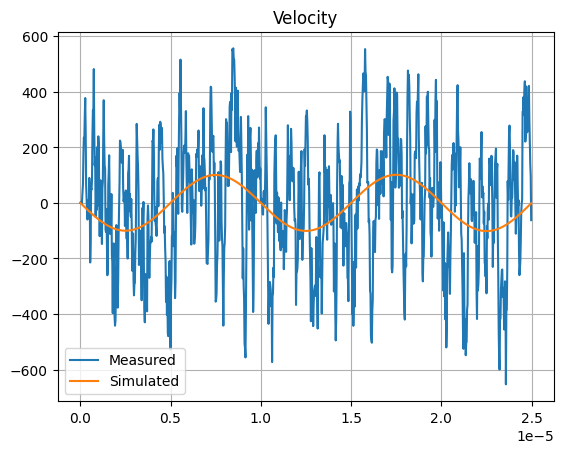

In [62]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:1000], estimated_states[:1000,1])
plt.plot(t[:1000], new_states[:1000,1])
plt.grid()
plt.legend(['Measured', 'Simulated', 'Estimated'])
plt.show()